In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from numpy.random import randn, randint
from keras.datasets.mnist import load_data
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
#from google.colab import drive
import matplotlib.image as mpimg

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
train_images = X_train.reshape(-1, 28, 28, 1)

In [4]:
train_images = (train_images - 127.5) / 127.5

In [5]:
selected = y_train == 3
train_ds = train_images[selected]

In [6]:
len(train_ds)

6131

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(300).batch(64)

In [8]:
train_ds

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

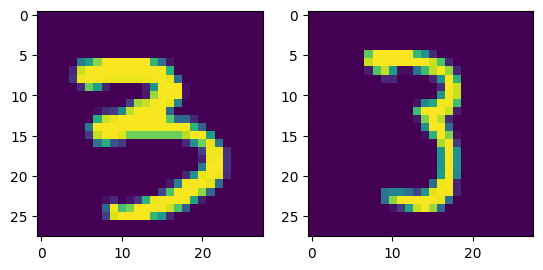

In [9]:
for image in train_ds.take(1):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(image[i, :, :, 0].numpy())

In [10]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)

In [11]:
 
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02, seed=42)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization()) #kernel_constraint=const
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization()) #kernel_constraint=const
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1)) #kernel_constraint=const
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02, seed=42)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [23]:
generator = define_generator(100)
critic = define_critic()

tf.Tensor(
[[[[ 2.06211349e-03]
   [-2.11679842e-02]
   [ 5.85214747e-03]
   [-1.48885651e-02]
   [-1.12538747e-02]
   [-2.57573593e-02]
   [-2.97916238e-03]
   [-9.21283755e-03]
   [ 1.05222231e-02]
   [-1.09298555e-02]
   [ 2.01162766e-03]
   [-1.34493541e-02]
   [ 2.35648863e-02]
   [-3.47981788e-02]
   [ 1.04574403e-02]
   [-1.79658143e-03]
   [-1.60893134e-03]
   [-3.60084744e-03]
   [ 9.42587852e-03]
   [ 1.71321593e-02]
   [-6.42062398e-03]
   [ 3.27206007e-03]
   [-1.00944582e-02]
   [-1.96598005e-02]
   [-7.38328882e-03]
   [-1.66538302e-02]
   [ 1.10291294e-05]
   [-5.23381168e-03]]

  [[-2.72745965e-04]
   [ 1.77002547e-03]
   [ 1.51329702e-02]
   [ 2.47378740e-02]
   [ 2.00552922e-02]
   [-1.35755334e-02]
   [ 1.52707556e-02]
   [ 2.35954188e-02]
   [-2.44673155e-02]
   [-4.16504638e-03]
   [ 1.18046077e-02]
   [-2.42571020e-03]
   [ 1.77048203e-02]
   [-1.99200977e-02]
   [ 2.87699364e-02]
   [-6.19879412e-03]
   [ 2.72395778e-02]
   [-3.31232627e-03]
   [-8.42864439e-03]


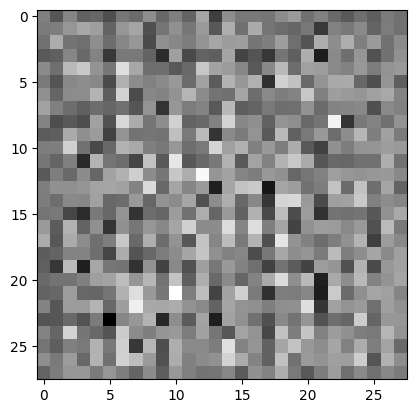

In [24]:
def generate_fake(n_samples, n_classes, latent_dim):
    labels = np.random.randint(0, n_classes, n_samples)
    noise = tf.random.normal([n_samples, latent_dim])
    return noise, labels

noise, labels = generate_fake(1, 10, 100)

gen_img = generator(noise)
print(gen_img)

plt.imshow(gen_img[0,:,:,0], cmap='gray')

In [25]:
class GAN(keras.Model):
    def __init__(self, critic, generator):
        super(GAN, self).__init__()
        self.critic = critic
        self.generator = generator
        

    def compile(self, c_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
    
    # wasserstein distance for the discriminator
    def critic_loss(self, real, fake):
        real_loss = tf.reduce_mean(real)
        fake_loss = tf.reduce_mean(fake)
        total_loss = fake_loss - real_loss
        return total_loss

    # the generator tries to move the gen_images to the real images distribution
    def generator_loss(self, fake):
        fake_loss = -(tf.reduce_mean(fake))
        return fake_loss

    def train_step(self, batch, n_critic=5):
        #tr_image, tr_label = batch
        noise, labels = generate_fake(64, 10, 100)
        # update the critic more.
        for i in range(n_critic):
            with tf.GradientTape() as cr_tape:
                generated = self.generator(noise, training=True)
                real = self.critic(batch, training=True)
                fake = self.critic(generated, training=True)
                cr_loss = self.critic_loss(real, fake)

                cr_grad = cr_tape.gradient(cr_loss, self.critic.trainable_variables)
                self.c_optimizer.apply_gradients(zip(cr_grad, self.critic.trainable_variables))
                
        with tf.GradientTape() as gen_tape: 
            generated_image = self.generator(noise, training=True)
            cr_gen_img = self.critic(generated_image, training=True)

            gen_loss = self.generator_loss(cr_gen_img)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        return {"cr_loss": cr_loss, "g_loss": gen_loss}

In [26]:
WGAN = GAN(critic=critic, generator=generator)

In [27]:
WGAN.compile(c_optimizer=RMSprop(learning_rate=0.00005),
             g_optimizer=RMSprop(learning_rate=0.00005))

In [28]:
epochs = 50
seed = tf.random.normal([16, 100])
#labels = np.random.randint(0, 10, 16)

In [29]:
#path = '/content/drive/My Drive/colab_notebooks/wgan_images/'

class Generate(keras.callbacks.Callback):
    def __init__(self):
        super(Generate, self).__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        prediction = generator(seed)

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(prediction[i, :, :, 0], cmap='gray')
            plt.axis('off')
            
        plt.savefig(f'image at epoch {epoch+1}.png')
        plt.show()

Epoch 1/50
96/96 [==============================] - ETA: 0s - cr_loss: -28.6041 - g_loss: 8.3150

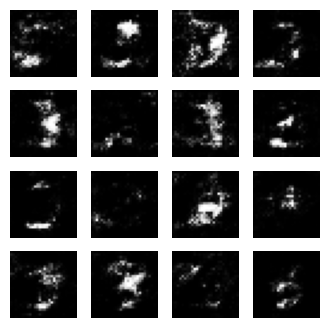

96/96 [==============================] - 468s 5s/step - cr_loss: -28.7277 - g_loss: 8.3358
Epoch 2/50
 7/96 [=>............................] - ETA: 7:41 - cr_loss: -40.1877 - g_loss: 12.1774

KeyboardInterrupt: 

In [30]:
WGAN.fit(train_ds, epochs=50, callbacks=[Generate()])

In [ ]:
Generate().on_epoch_end(0)

In [45]:
for image in train_ds.take(1):
    disc = critic(image)
    fake = critic(generator(tf.random.normal([64, 100])))

In [46]:
tf.reduce_mean(disc*-(tf.ones_like(disc)))

<tf.Tensor: shape=(), dtype=float32, numpy=-1.1897485>

In [47]:
K.mean(fake*(tf.ones_like(fake)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.03250167>

In [49]:
fake

<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[ 0.03777957],
       [ 0.04776618],
       [ 0.02336919],
       [ 0.0500405 ],
       [ 0.05893546],
       [ 0.02535053],
       [ 0.03052945],
       [ 0.05276126],
       [ 0.02466796],
       [ 0.0083583 ],
       [ 0.04798985],
       [ 0.0434635 ],
       [ 0.02282563],
       [ 0.03702849],
       [ 0.05437787],
       [ 0.03816235],
       [ 0.03980958],
       [ 0.01414186],
       [ 0.03358172],
       [ 0.04079339],
       [ 0.04678276],
       [ 0.05958775],
       [ 0.04516837],
       [ 0.04631869],
       [ 0.03216636],
       [ 0.02200092],
       [ 0.01368891],
       [ 0.02942909],
       [ 0.03661355],
       [ 0.026246  ],
       [-0.01016209],
       [ 0.03075776],
       [ 0.04316238],
       [ 0.03539048],
       [ 0.05716981],
       [ 0.03849331],
       [ 0.04891363],
       [ 0.03879382],
       [ 0.01248066],
       [ 0.01508461],
       [ 0.05955938],
       [ 0.02021393],
       [ 0.00251813],
     